SET PARAMETERS

In [103]:
# initialize params
DEBUG = True
saveReport = False
toPrint = True
reportName = 'notebook'
txt_label = "Classification of integrated c1 and c2 CNVs samples"
sample_class_column = "Relapsed"
class_labels = ["relapsed","NOTrelapsed"]
class_values = [1,0]

# classification params
split_train_size = 40
split_random_state = 0

# plotting params
function_dict = None
with_swarm = False
highRes = False
if highRes:
    img_ext = '.pdf'
else:
    img_ext = '.png'
cmap_custom = None
vmin, vmax = (-2, +2)
plot_kwargs = {
    "mincol":"red",
    "midcol":"white",
    "maxcol":"blue",
}

In [2]:
# file paths
data_fpath = "output/headneck/integrate_cohorts/c1c2/CNV_mapped_filt/integrated_data.csv"
sample_info_fpath = "output/headneck/integrate_cohorts/c1c2/integrated_sample_info.csv"
gene_info_fpath = "output/headneck/integrate_cohorts/c1c2/genes_info.csv"
output_directory = "output/headneck/classification/"+reportName

In [3]:
# arguments to load the sample_info file
sample_info_read_csv_kwargs = {
    "sep": "\t",
    "header": 0,
    "col_as_index":"patientID"
}

In [4]:
# select features
genepanel_path = "output/headneck/setup_c1_genepanel/process_select_primary/data_processed.csv"
_dirs = ['c1_prmr_OncFltNxEx', 'c2_ExcvFltNxEx', 'c1_prmr_mapped_c2_CnvNxEx', 'c1_prmr_mapped_c2_Cnv', 'c1_prmr_mapped_c2_CnvMixedNxEx']
_key_names = ['c1_OncFltNxEx', 'c2_ExcvFltNxEx', 'c3_CnvNxEx', 'c3_Cnv', 'c3_CnvMixedNxEx']

SET ENVIRONMENT

In [87]:
# custom imports
from omics_processing.io import (
    set_directory, load_clinical
)
from omics_processing.remove_duplicates import (
    remove_andSave_duplicates
)
from gene_signatures.core import (
    custom_div_cmap,
    get_chr_ticks,
    choose_samples,
    parse_arg_type,
    boxplot,
    set_heatmap_size,
    set_cbar_ticks,
    edit_names_with_duplicates
)

# basic imports
import os, sys
import numpy as np
import pandas as pd
import json
from scipy.spatial.distance import pdist, squareform
from natsort import natsorted, index_natsorted
import math
import logging
from sklearn import linear_model
from sklearn import svm
from distutils.util import strtobool
from scipy.stats import binom_test
from sklearn.externals import joblib
from sklearn.model_selection import StratifiedKFold, train_test_split

# plotting imports
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')

script_path = os.getcwd()
logger = logging.getLogger(__name__)

START ANALYSIS

In [6]:
if DEBUG:
    logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

In [7]:
def check_path_integrity(f,rootDir=None, name="", force=False):
    if not os.path.exists(f):
        f = os.path.join(*f.rsplit('/'))
        f = os.path.join(rootDir, f)
        if force:
            f = set_directory(f)
        logger.debug("set "+name+" fpath:\n"+f)
    return f

In [16]:
# properly set file paths
try:
    os.path.exists(MainDataDir)
except:
    MainDataDir = os.path.join(script_path, '..','..', 'data')
    logger.debug("set MainDataDir:\n"+MainDataDir)

# data input
data_fpath = check_path_integrity(data_fpath, rootDir=MainDataDir, name="data")

# sample info input
sample_info_fpath = check_path_integrity(sample_info_fpath, rootDir=MainDataDir, name="sample_info")

# gene info input
gene_info_fpath = check_path_integrity(gene_info_fpath, rootDir=MainDataDir, name="gene_info")

# data output
output_directory = check_path_integrity(output_directory, rootDir=MainDataDir, name="output", force=True)

In [12]:
# fpaths_dict
fpaths_dict = {}
fpaths_dict['genepanel'] = check_path_integrity(genepanel_path, rootDir=MainDataDir, name="genepanel features")

for _f, _k in zip(_dirs, _key_names):
    fpath = "output/headneck/feature_selection/"+_f+"/featsel_results.csv"
    fpaths_dict[_k] = check_path_integrity(fpath, rootDir=MainDataDir, name=_k+" features")
    

DEBUG:__main__:set genepanel features fpath:
/Users/lle/GitRepos/myRepos/gene_signatures/examples/notebooks/../../data/output/headneck/setup_c1_genepanel/process_select_primary/data_processed.csv
DEBUG:__main__:set c1_OncFltNxEx features fpath:
/Users/lle/GitRepos/myRepos/gene_signatures/examples/notebooks/../../data/output/headneck/feature_selection/c1_prmr_OncFltNxEx/featsel_results.csv
DEBUG:__main__:set c2_ExcvFltNxEx features fpath:
/Users/lle/GitRepos/myRepos/gene_signatures/examples/notebooks/../../data/output/headneck/feature_selection/c2_ExcvFltNxEx/featsel_results.csv
DEBUG:__main__:set c3_CnvNxEx features fpath:
/Users/lle/GitRepos/myRepos/gene_signatures/examples/notebooks/../../data/output/headneck/feature_selection/c1_prmr_mapped_c2_CnvNxEx/featsel_results.csv
DEBUG:__main__:set c3_Cnv features fpath:
/Users/lle/GitRepos/myRepos/gene_signatures/examples/notebooks/../../data/output/headneck/feature_selection/c1_prmr_mapped_c2_Cnv/featsel_results.csv
DEBUG:__main__:set c3_C

In [15]:
fpaths_dict.keys()

dict_keys(['genepanel', 'c1_OncFltNxEx', 'c2_ExcvFltNxEx', 'c3_CnvNxEx', 'c3_Cnv', 'c3_CnvMixedNxEx'])

In [104]:
if (cmap_custom is None) and (vmin is not None) and (vmax is not None):
    custom_div_cmap_arg = abs(vmin)+abs(vmax)
    if (vmin <= 0) and (vmax >= 0):
        custom_div_cmap_arg = custom_div_cmap_arg + 1
    mincol = plot_kwargs.get('mincol', None)
    midcol = plot_kwargs.get('midcol', None)
    maxcol = plot_kwargs.get('maxcol', None)
    if (
            (mincol is not None) and
            (midcol is not None) and
            (maxcol is not None)
            ):
        cmap_custom = custom_div_cmap(
            numcolors=custom_div_cmap_arg,
            mincol=mincol, midcol=midcol, maxcol=maxcol)
    else:
        cmap_custom = custom_div_cmap(numcolors=custom_div_cmap_arg)

In [102]:
cmap_custom

In [18]:
# load data
data = pd.read_csv(data_fpath, sep='\t', header=0, index_col=0)
logger.info('loaded data file with shape: '+str(data.shape))

INFO:__main__:loaded data file with shape: (61, 18417)


In [19]:
data.head()

,AADACL3,AADACL4,ACOT7,AGTRAP,AJAP1,ANGPTL7,APITD1-CORT,C1orf127,C1orf158,C1orf167,...,TTTY8,TTTY9B,USP9Y,UTY,VCY,XKRY,ZFY,BCORP1,CD24,KDM5D
1Rpr,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2Rpr,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3Rpr,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-2.0,0.0,0.0,0.0,-2.0,0.0,-2.0,-2.0,-2.0
4Rpr,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5Rpr,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0


In [20]:
# load info table of samples
sample_info = load_clinical(
    sample_info_fpath, **sample_info_read_csv_kwargs)
logger.info('loaded sample_info file with shape: '+str(sample_info.shape))

INFO:omics_processing.io:Load clinical file: /Users/lle/GitRepos/myRepos/gene_signatures/examples/notebooks/../../data/output/headneck/integrate_cohorts/c1c2/integrated_sample_info.csv
INFO:__main__:loaded sample_info file with shape: (75, 11)


In [21]:
sample_info.head()

,Unnamed: 0,varID,cnvID,patient,tumor,class_description,Tcode,Ccode,dataset,Local_Control,Relapsed
patientID,,,,,,,,,,,
1Rpr,0,Rad2_MR,DS-107_0002,1.0,primary,Responder,0.0,0.0,0,NaN,0.0
2Rpr,1,Rad3_MR,DS-107_0003,2.0,primary,Responder,0.0,0.0,0,NaN,0.0
3Rpr,2,Rad4_MR,DS-107_0004,3.0,primary,Responder,0.0,0.0,0,NaN,0.0
4Rpr,3,Rad5_MR,DS-107_0005,4.0,primary,Responder,0.0,0.0,0,NaN,0.0
5Rpr,4,Rad6_MR,DS-107_0006,5.0,primary,Responder,0.0,0.0,0,NaN,0.0


In [22]:
# load info table of genes
gene_info = pd.read_csv(gene_info_fpath, sep='\t', header=0, index_col=0)
logger.info('loaded gene_info file with shape: '+str(gene_info.shape))

INFO:__main__:loaded gene_info file with shape: (25730, 8)


In [23]:
# set the ground truth
ground_truth = sample_info.loc[data.index, sample_class_column]

In [24]:
ground_truth.head()

1Rpr    0.0
2Rpr    0.0
3Rpr    0.0
4Rpr    0.0
5Rpr    0.0
Name: Relapsed, dtype: float64

In [64]:
def extract_gene_set(df):
    gene_set = set()
    if 'dupl_genes' in df.columns:
        dupl_col = df['dupl_genes']
        dupl_set = set([
            item for sublist in dupl_col 
            if isinstance(sublist, str) 
            for item in eval(sublist)
        ])
        gene_set = gene_set.union(set(dupl_set))

        if 'cleanName' in df.columns:
            gene_set = gene_set.union(set(df['cleanName'].values))
    else:
        gene_set = gene_set.union(set(df.index.values))
        
    return gene_set


In [66]:
features_dict = {}
features_sets = {}
for key in fpaths_dict:
    
    df = pd.read_csv(fpaths_dict[key], sep='\t', header=0, index_col=0)
    
    if 'genepanel' in key:
        features_sets[key] = set(df.columns.values)
        n_total = len(features_sets[key])
        n_unique = n_total
    else:
        features_dict[key] = df
        features_sets[key] = extract_gene_set(df)
        n_total = len(features_sets[key])
        n_unique = df.shape[0]
        
    logger.info(str(n_unique)+' unique out of '+str(n_total)+' total features from '+key)

INFO:__main__:16 unique out of 16 total features from genepanel
INFO:__main__:4 unique out of 40 total features from c1_OncFltNxEx
INFO:__main__:30 unique out of 150 total features from c2_ExcvFltNxEx
INFO:__main__:137 unique out of 693 total features from c3_CnvNxEx
INFO:__main__:6238 unique out of 15666 total features from c3_Cnv
INFO:__main__:3 unique out of 6 total features from c3_CnvMixedNxEx


In [96]:
# split data in train-test ONCE!
stratify_by = pd.concat([ground_truth, sample_info['dataset']], axis=1, sort=False)
stratify_by = stratify_by.loc[data.index]

In [97]:
data_train, data_test, y_train, y_test = train_test_split(
    data, ground_truth,
    train_size=split_train_size,
    test_size=None,
    random_state=split_random_state,
    stratify=stratify_by
)

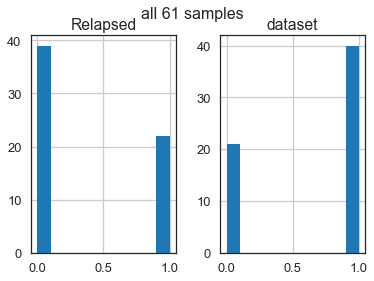

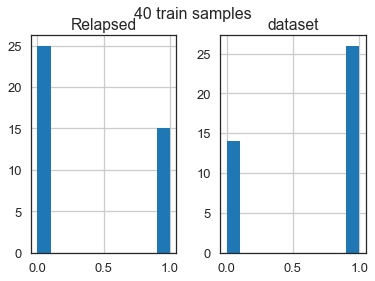

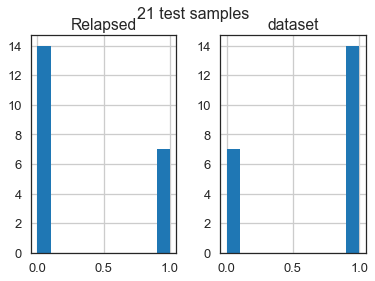

In [98]:
stratify_by.hist()
plt.suptitle('all '+str(data.shape[0])+' samples', fontsize=16)
stratify_by.loc[data_train.index].hist()
plt.suptitle(str(data_train.shape[0])+' train samples', fontsize=16)
stratify_by.loc[data_test.index].hist()
plt.suptitle(str(data_test.shape[0])+' test samples', fontsize=16)
plt.show()

In [99]:
# REMOVE DUPLICATES!!!!
uniqdata, dupldict, uniqSet, allduplSet = remove_andSave_duplicates(
    data_train, to_compute_euclidean_distances=True,
    to_save_euclidean_distances=True, to_save_output=True,
    output_filename='train_data_wo_duplicates',
    output_directory=output_directory
)

INFO:omics_processing.remove_duplicates:Load data from input.
INFO:omics_processing.remove_duplicates:size before checking for duplicate columns: (40, 18417)
INFO:omics_processing.remove_duplicates:replace zero vectors with value: 0.0001
INFO:omics_processing.remove_duplicates:computing genes euclidean distances...
INFO:omics_processing.remove_duplicates:>time: 6.8969290719833225
INFO:omics_processing.remove_duplicates:save genes euclidean distances in: /Users/lle/GitRepos/myRepos/gene_signatures/examples/notebooks/../../data/output/headneck/classification/notebook/train_data_wo_duplicates__genes_pdist_eucl.h5
INFO:omics_processing.remove_duplicates:finding duplicate genes...
INFO:omics_processing.remove_duplicates:removing duplicate genes...
INFO:omics_processing.remove_duplicates: -data shape w/ duplicates: (40, 18417)
INFO:omics_processing.remove_duplicates: -number of genes w/o duplicates (unique): 417
INFO:omics_processing.remove_duplicates: -all gene duplicates: 18000
INFO:omics_

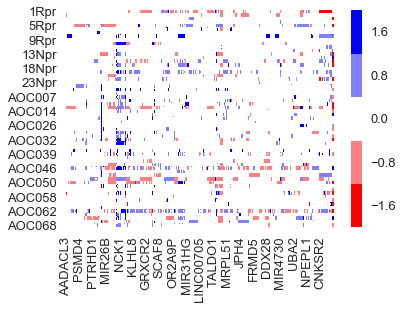

In [105]:
sns.heatmap(data, cmap = cmap_custom, vmin=vmin, vmax=vmax)

In [114]:
orphancols = np.where(abs(data_train).sum(axis=0) == 0)[0]

In [115]:
orphancols.shape

(1634,)

In [116]:
data_train.columns[orphancols]

Index(['AKT3', 'CEP170', 'CHML', 'CHRM3', 'EXO1', 'FH', 'FMN2', 'GREM2', 'KMO',
       'MAP1LC3C',
       ...
       'ZNF709', 'ZNF788', 'ZNF799', 'ZNF812', 'ZNF823', 'ZNF833P', 'ZNF844',
       'ZNF846', 'ZNF878', 'APLP1'],
      dtype='object', length=1634)

In [117]:
uniqdata.shape

(40, 1292)

In [120]:
set(uniqdata.columns.values).intersection(set(data_train.columns.values[orphancols]))

{'AKT3'}